In [1]:
import torch                     # for all things PyTorch
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

# Sample Pytorch Model

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Convulutional layers
        # 1 input image channel (black & white), 6 output channels, 3x3 square convolution
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        # Fully connected layers
        # an affine (linear) operation: y = Wx + b

        # Why is 6x6 from image dimension: see details below: x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # Forward Propagation
    def forward(self, x):   
        # x is the data input
        print('x as raw input: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 1, 32, 32])
        

        # Basic idea: output from an upper layer will be the input of a lower layer

        # Demo output for first conv, relu and maxpool layer, remaining are similar
        x = self.conv1(x)
        print('x after 1st conv: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 6, 30, 30])

        x = F.relu(x)
        print('x after 1st relu: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 6, 30, 30])

        x = F.max_pool2d(x, (2, 2))     # Max pooling over a 2x2 window: decrease original size of layer by half
        print('x after 1st maxpool: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 6, 15, 15])

        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # [1, 6, 15, 15] -> [1, 16, 13, 13] -> [1, 16, 6, 6]
        print('x after 2nd maxpool: ', x)   
        print('x.shape: ', x.shape)     # torch.Size([1, 16, 6, 6])
        
        # Flatten x into 1D array
        # Caluculation: [1, 16, 6, 6] = 16*6*6 = 576 (All dimension except batch size) -> self.num_flat_features(x) = 576
        x = x.view(-1, self.num_flat_features(x))  
        print('x before entering fully connected layer: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 576])  1 is the batch size

        x = F.relu(self.fc1(x))
        print('x after 1st fully connected layer: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 120])

        x = F.relu(self.fc2(x))
        print('x after 2nd fully connected layer: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 84])

        x = self.fc3(x)
        print('x after 3rd fully connected layer: ', x)
        print('x.shape: ', x.shape)     # torch.Size([1, 10])

        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]     # All dimension except batch size
        print('size: ', size)
        num_features = 1
        for s in size:
            num_features *= s
        print('\nnum_features: ', num_features)
        return num_features

In [ ]:
# Model Instance
net = LeNet()
print(net)

# 1st arg: batch size, 2nd: color channel
input = torch.rand(1, 1, 32, 32)    # stand-in for a 32x32 black & white image
print('\nImage Batch Shape:')       
print(input.shape)                  # torch.Size([1, 1, 32, 32])

output = net(input)
print('\nRaw Input:')
print(output)
print(output.shape)


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image Batch Shape:
torch.Size([1, 1, 32, 32])
x as raw input:  tensor([[[[0.9618, 0.6188, 0.3935,  ..., 0.3476, 0.6521, 0.3630],
          [0.5558, 0.9740, 0.8427,  ..., 0.1110, 0.1566, 0.0797],
          [0.1082, 0.6784, 0.3450,  ..., 0.3530, 0.2016, 0.0760],
          ...,
          [0.3618, 0.9430, 0.8515,  ..., 0.5175, 0.9431, 0.0643],
          [0.7678, 0.7331, 0.6986,  ..., 0.9976, 0.1152, 0.8072],
          [0.7509, 0.0295, 0.6179,  ..., 0.5351, 0.9755, 0.3385]]]])
x.shape:  torch.Size([1, 1, 32, 32])
x after 1st conv:  tensor([[[[ 0.4623,  0.1255,  0.1527,  ...,  0.1839,  0.3039,  0.3108],
          [ 0.5802,  0.5322,  0.3690,  ...,  0.0760, -0.0903, -0.0127],
          [

# Hands-on Pytorch Model

## Datasets and Dataloaders

Here will demonstrate using one of the ready-to-download, open-access datasets from TorchVision, how to transform the images for consumption by your model, and how to use the DataLoader to feed batches of data to your model.

The first thing we need to do is transform our incoming images into a PyTorch tensor.


Next, we’ll create an instance of the **CIFAR10** dataset. This is a set of 32x32 color image tiles representing 10 classes of objects: 6 of animals (bird, cat, deer, dog, frog, horse) and 4 of vehicles (airplane, automobile, ship, truck)

In [3]:
import torch 
import torchvision
import torchvision.transforms as transforms

In [4]:
# transform our incoming images into a PyTorch tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # converts images loaded by Pillow into PyTorch tensors.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5):
# adjusts the values of the tensor so that their average is zero and 
# their standard deviation is 0.5. Most activation functions have their 
# strongest gradients around x = 0, so centering our data there can speed learning.

In [5]:
# Creating a dataset object in PyTorch. 
# Downloadable datasets (like CIFAR-10 above) are subclasses of torch.utils.data.Dataset. 

# Case 1: Download from Internet to current directory
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Case 2: Already downloaded to ./data folder
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
# Case 1: Download from Internet to current directory
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Case 2: Already downloaded to ./data folder
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

Files already downloaded and verified


In [7]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [8]:
# A batch of 4 pictures will be loaded
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [9]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [10]:
print(trainloader)

## Visualize batches that DataLoader serves

torch.Size([4, 3, 32, 32])
torch.Size([4])
(3, 36, 138)
  cat  ship  frog  deer


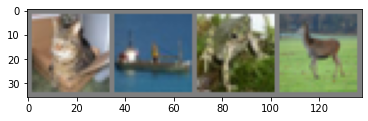

In [15]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # print('Unnormalize', npimg)
    print(npimg.shape)      # (3, 36, 138): 4 images are 'concatenated' together

    # np.transpose(numpy_image, rearrange dimensions by putting color channel at the end)
    # plt.imshow() arg: (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)     # torch.Size([4, 3, 32, 32])
print(labels.shape)     # torch.Size([4])
# print('1st image:\n', images[0])    # A bunch of numbers

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Model

In [16]:
# A variant of LeNet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Loss Function & Optimizer

In [17]:
import torch.optim as optim

In [18]:
criterion = nn.CrossEntropyLoss()

# The optimizer is what drives the learning. 
# net.paramters() contains all the params of the model, it is what optimizer try to adjust during learning
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [ ]:
# Go through whole training dataset twice only for demo: more is better
for epoch in range(2):
    running_loss = 0.0
    # iterate through each batch=4 -> process 4 images at a time
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data

        # Zero the parameter gradient for each batch 
        optimizer.zero_grad()

        # forward + backward + optimize

        # ask the model for its predictions on this batch
        outputs = net(inputs)

        # compute the loss
        loss = criterion(outputs, labels)

        # do the backward() pass, and calculate the gradients that will direct the learning
        loss.backward()

        # Use the gradients from backward() to adjust the weights in a direction it think will reduce the loss
        optimizer.step()

        # Print statistics
        # does some light reporting on the epoch number, 
        # how many training instances have been completed, 
        # and what the collected loss is over the training loop.
        running_loss += loss.item()
        if i % 2000 == 1999:    # i: which data is being processed
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.252
[1,  4000] loss: 1.893
[1,  6000] loss: 1.664
[1,  8000] loss: 1.585
[1, 10000] loss: 1.502
[1, 12000] loss: 1.430
[2,  2000] loss: 1.390
[2,  4000] loss: 1.376
[2,  6000] loss: 1.343
[2,  8000] loss: 1.338
[2, 10000] loss: 1.299
[2, 12000] loss: 1.293
Finished Training


## Evaluation on TestSet

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    # Test data are also divided into batches of size 4
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


# Other Examples

In [ ]:
# Extra examples about max pooling

# pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = m(input)

print('Output.shape: ', output.shape)
print('Output: ', output)

In [ ]:
# Extra examples about relu

m = nn.ReLU()
input = torch.randn(2)
print('Input: ', input)
output = m(input)
print('Output: ', output)

# m = nn.ReLU()
# input = torch.randn(2).unsqueeze(0)
# output = torch.cat((m(input),m(-input)))